# Data Challenge - Exploratory Data Analysis

In this notebook, we explore a dataset of image pairs focused on underwater image restoration. The goal is to analyze the characteristics of these images and understand how they differ in terms of quality and content. Underwater images often suffer from issues like blurriness, low contrast, and color distortion due to light scattering and absorption. This analysis will help identify key challenges in restoring and enhancing underwater images.

In future steps, we plan to include an additional dataset for super-resolution, which aims to increase the resolution of images and recover fine details. While image restoration focuses on improving quality by correcting distortions, super-resolution focuses on enhancing image clarity by reconstructing higher-resolution versions.

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("matplotlib:", matplotlib.__version__)

random_seed = 42
random.seed(random_seed)

NumPy version: 1.26.3
Pandas version: 2.2.3
matplotlib: 3.9.2


In [3]:
class LazyImageLoader:
    def __init__(self, root):
        """
        Initializes the LazyImageLoader object.

        Args:
            root (str): Path to the folder containing images.
        """
        self.filesA, self.filesB = self.get_file_paths(root)
        self.len = min(len(self.filesA), len(self.filesB))
        
    def __len__(self):
        """
        Returns the total number of image pairs.

        Returns:
            int: Number of image pairs.
        """
        return self.len
    
    def __getitem__(self, index):
        """
        Loads and returns the image at the given index of filesA and filesB.

        Args:
            index (int): Index of the image pair to load.

        Returns:
            tuple: A tuple of the loaded images (PIL Image objects).

        Raises:
            IndexError: If the index is out of range.
            ValueError: If the image could not be loaded.
        """
        if index < 0 or index >= self.len:
            raise IndexError("Index out of range.")

        try:
            imageA = Image.open(self.filesA[index]).convert('RGB')
            imageB = Image.open(self.filesB[index]).convert('RGB')
        except Exception as e:
            raise ValueError(f"Image could not be loaded: {e}")

        return imageA, imageB
    
    def get_file_paths(self, root):
        """
        Recursively retrieves file paths from 'trainA' and 'trainB' subdirectories.

        Args:
            root (str): The root directory of the EUVP dataset.

        Returns:
            tuple: Two lists, filesA and filesB, containing the file paths.
        """
        sub_dirs = ['underwater_imagenet', 'underwater_dark', 'underwater_scenes']
        filesA, filesB = [], []

        for sub_dir in sub_dirs:
            sub_dir_path = os.path.join(root, sub_dir)
            if os.path.exists(sub_dir_path):
                for dirpath, _, filenames in os.walk(sub_dir_path):
                    if 'trainA' in dirpath:
                        for filename in filenames:
                            filesA.append(os.path.join(dirpath, filename))
                    elif 'trainB' in dirpath:
                        for filename in filenames:
                            filesB.append(os.path.join(dirpath, filename))
            else:
                print(f"Warning: Subdirectory '{sub_dir}' does not exist in the root path.")

        return filesA, filesB
    
    def display(self, index):
        """
        Displays a pair of images (Image A and Image B) side by side with their filenames as titles.
    
        Parameters:
        index (int): The index of the image pair to display.
        """
        imageA, imageB = self[index]
        
        filenameA = os.path.basename(self.filesA[index])
        filenameB = os.path.basename(self.filesB[index])
        
        fig, axes = plt.subplots(1, 2, figsize=(6, 3))
        axes[0].imshow(imageA)
        axes[0].set_title(f"Image A - {filenameA}")
        axes[0].axis('off')

        axes[1].imshow(imageB)
        axes[1].set_title(f"Image B - {filenameB}")
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

## Image Example: Side by Side
We begin by displaying an example image pair side by side. This shows the degraded underwater image and its restored version. Visualizing these pairs helps us understand the nature of the restoration process and the types of improvements made.

Example of a pair side by side.


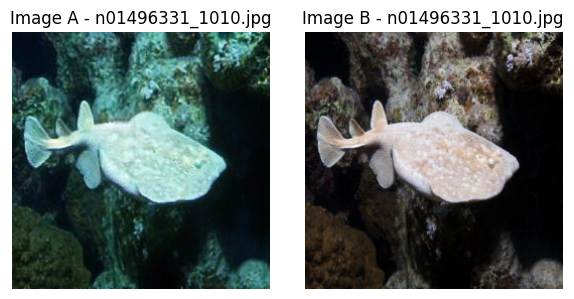

In [4]:
image_path = "../data/EUVP/Paired"
image_loader = LazyImageLoader(image_path)

print("Example of a pair side by side.")
image_loader.display(0)

## Dataset Summary
This section provides an overview of the underwater image dataset:

- Total Images: The total number of image pairs available.
- Unique Sizes: A count of distinct image resolutions.
- Brightness: The average brightness across the dataset, which helps gauge the overall lighting conditions in underwater environments.

These metrics give a sense of the dataset’s structure and highlight any patterns or inconsistencies.

In [5]:
def dataset_statistics(image_loader):
    """
    Computes and prints key statistics for the dataset, including image sizes and brightness levels.

    Parameters:
    image_loader (object): An iterable object that returns image pairs when indexed.
    """
    sizes = []
    brightness = []
    for i in tqdm(range(len(image_loader))):
        imageA, _ = image_loader[i]
        sizes.append(imageA.size)
        brightness.append(np.array(imageA).mean())

    size_counts = Counter(sizes)
    avg_brightness = np.mean(brightness)
    std_brightness = np.std(brightness)

    print("Dataset Summary:")
    print("----------------")
    print(f"Total Images: {len(image_loader)}")
    print(f"Unique Sizes: {len(size_counts)}")
    print("Image Size Frequencies:")
    for size, count in size_counts.items():
        print(f"  {size}: {count}")
    print(f"Average Brightness: {avg_brightness:.2f}")
    print(f"Brightness Std Dev: {std_brightness:.2f}")

dataset_statistics(image_loader)

100%|██████████| 11435/11435 [00:23<00:00, 482.89it/s]

Dataset Summary:
----------------
Total Images: 11435
Unique Sizes: 2
Image Size Frequencies:
  (256, 256): 9250
  (320, 240): 2185
Average Brightness: 99.48
Brightness Std Dev: 24.55


The dataset contains 11,435 images, with two main image sizes: 256x256 and 320x240. Most of the images (about 81%) are 256x256, while the remaining 19% are 320x240. The average brightness of the images is 99.48, which suggests a moderate light level across the dataset. The standard deviation of brightness is 24.55, showing some variation in brightness between the images. These statistics give useful information for future image processing tasks, such as image restoration, where both image size and brightness might affect the results.

## Image Size
A bar plot shows the distribution of image sizes, giving insight into whether the dataset primarily consists of images with similar resolutions or a mix of different sizes.

100%|██████████| 11435/11435 [00:12<00:00, 922.57it/s]


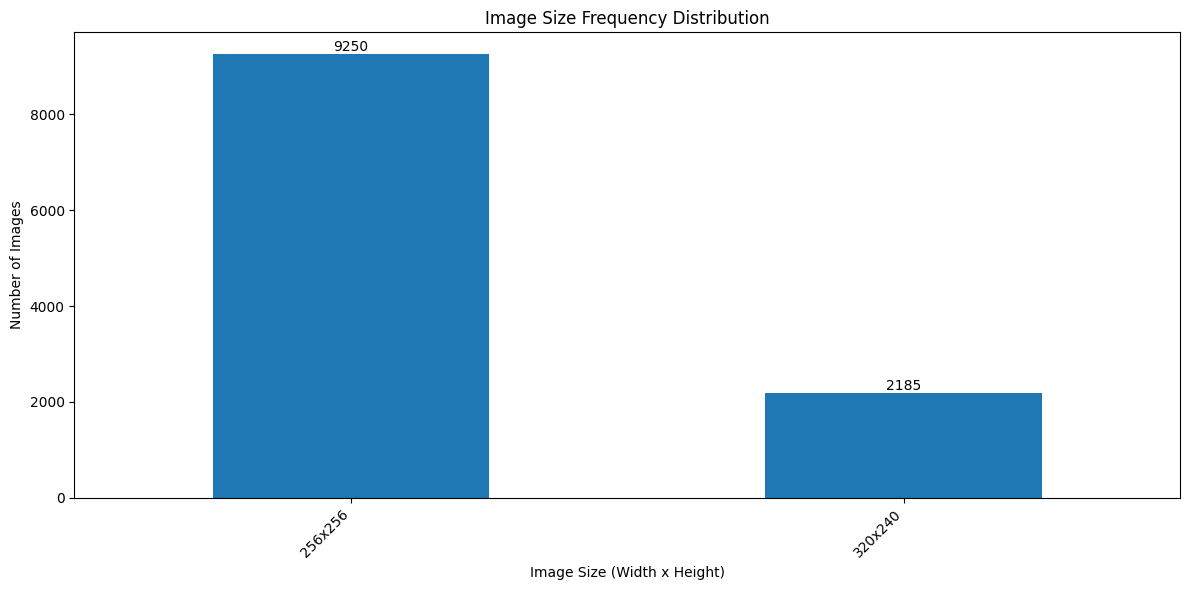

In [6]:
def image_size_counts(image_loader):
    """
    Computes and plots the distribution of image sizes in the dataset.
    
    Parameters:
    image_loader (object): An iterable object that returns image pairs when indexed.
    """
    sizes = []
    for i in tqdm(range(len(image_loader))):
        imageA, _ = image_loader[i]
        sizes.append(imageA.size)

    size_counts = Counter(sizes)
    size_df = pd.DataFrame.from_dict(size_counts, orient='index', columns=['Count'])
    size_df.index = size_df.index.map(lambda x: f'{x[0]}x{x[1]}')
    size_df = size_df.sort_values(by='Count', ascending=False)

    ax = size_df.plot(kind='bar', figsize=(12, 6), legend=False)
    plt.title('Image Size Frequency Distribution')
    plt.xlabel('Image Size (Width x Height)')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')
    
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black')
        
    plt.tight_layout()
    plt.show()

image_size_counts(image_loader)

## Image Grid: Collection of Image Pairs
We display a grid of image pairs, showcasing multiple examples of underwater images and their restored versions. This gives a wider view of the dataset and allows us to spot trends in how the restoration process addresses underwater distortions.

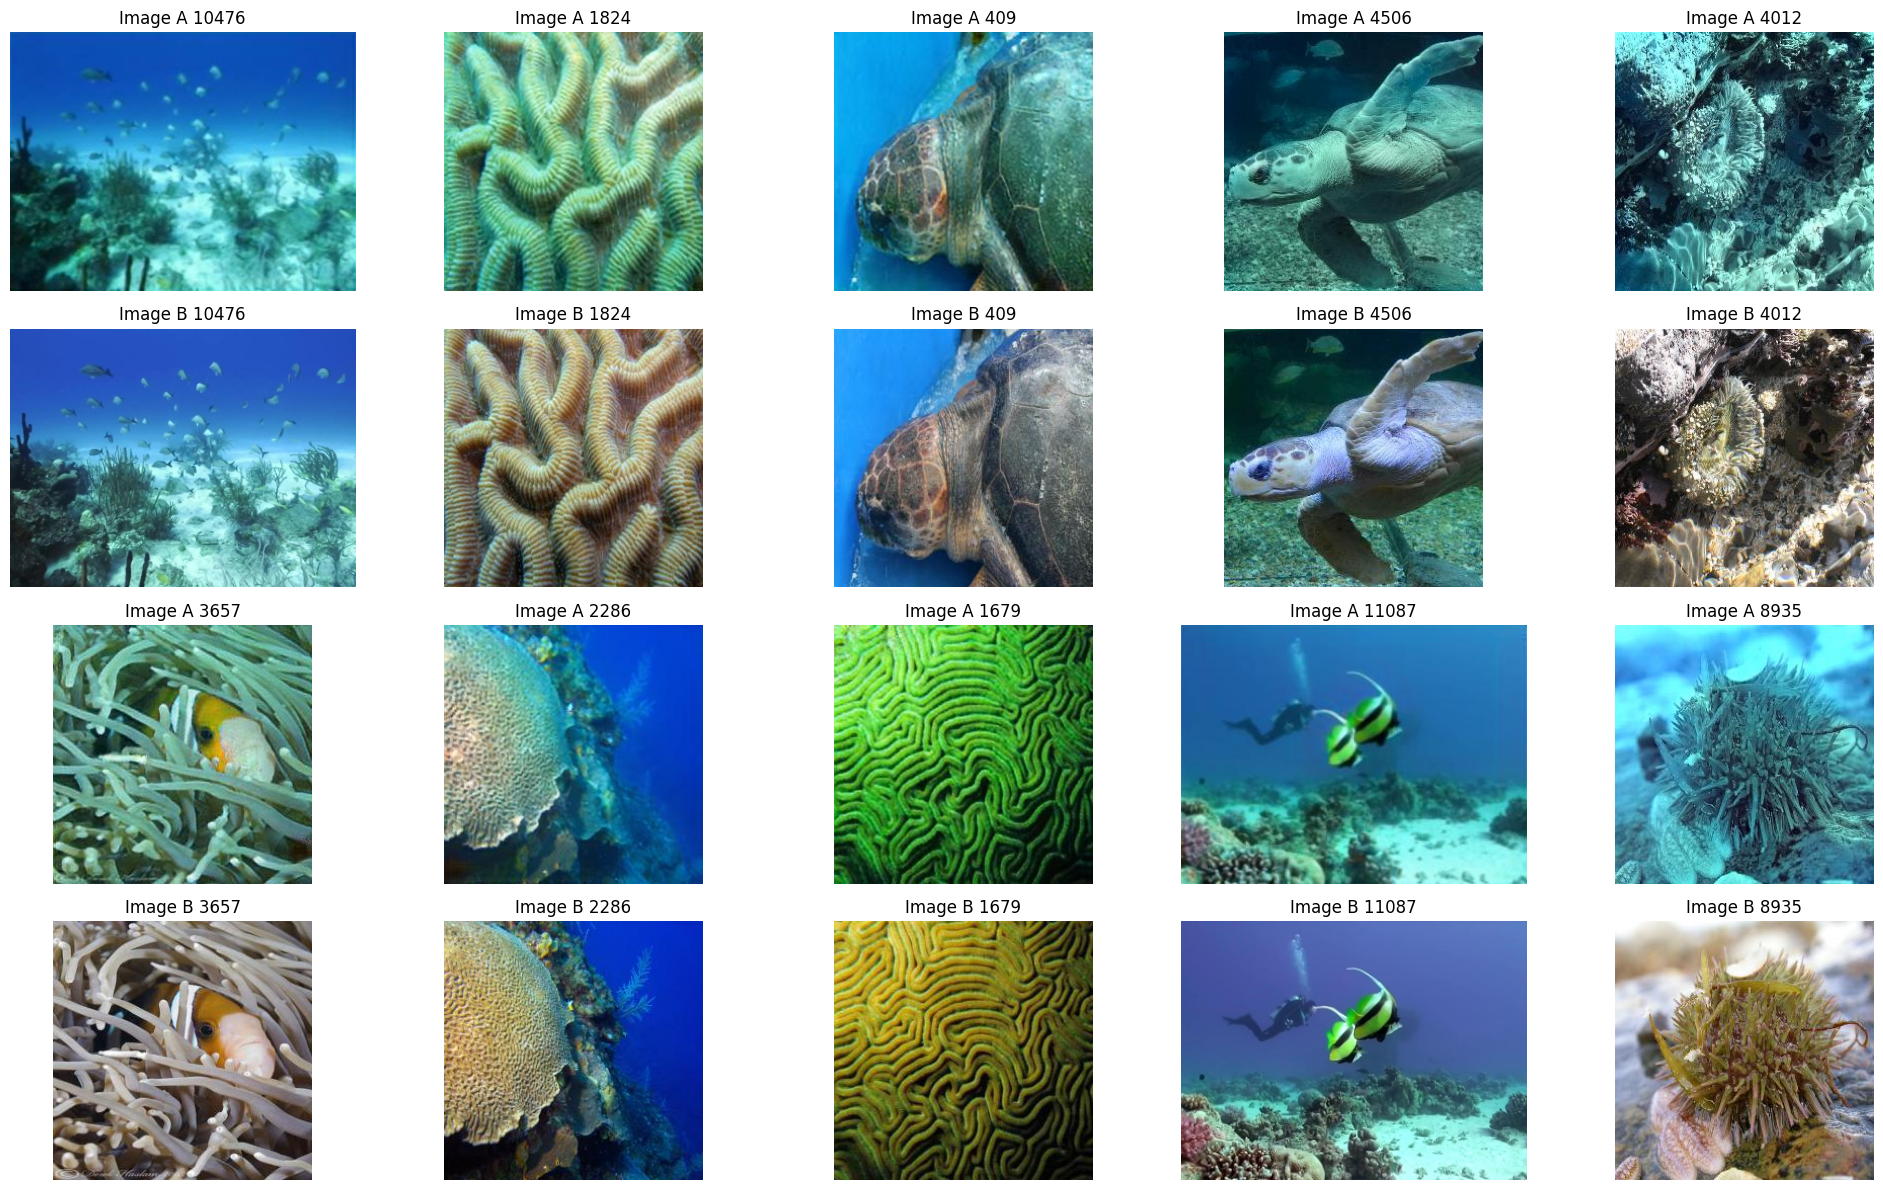

In [7]:
def show_random_image_grid(image_loader, num_images=10, images_per_row=5):
    """
    Displays a grid of random image pairs from the dataset, where each pair consists of 
    Image A and Image B displayed side by side.
    
    Parameters:
    image_loader (object): An iterable object that returns image pairs when indexed.
    num_images (int): The total number of random image pairs to display. Default is 10.
    images_per_row (int): The number of image pairs (A and B) to display per row. Default is 5.
    """
    random_indices = random.sample(range(len(image_loader)), num_images)
    
    num_rows = (num_images * 2) // images_per_row
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, num_rows * 3))

    for i, index in enumerate(random_indices):
        imageA, imageB = image_loader[index]
        
        row_A = (i // images_per_row) * 2
        col_A = i % images_per_row
        axes[row_A, col_A].imshow(imageA)
        axes[row_A, col_A].set_title(f'Image A {index}')
        axes[row_A, col_A].axis('off')

        row_B = row_A + 1
        col_B = col_A
        axes[row_B, col_B].imshow(imageB)
        axes[row_B, col_B].set_title(f'Image B {index}')
        axes[row_B, col_B].axis('off')

    plt.tight_layout()
    plt.show()

show_random_image_grid(image_loader)

## Pixel-wise Differences: Heatmap
A pixel-wise difference heatmap highlights the areas where the restored images differ the most from their degraded counterparts. This helps visualize which parts of the image are corrected during the restoration process.

In [8]:
random_indices = [random.randint(0, len(image_loader) - 1) for _ in range(2)]

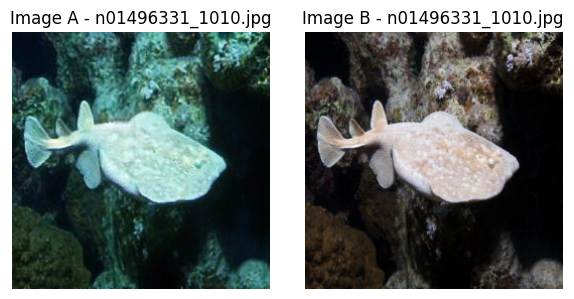

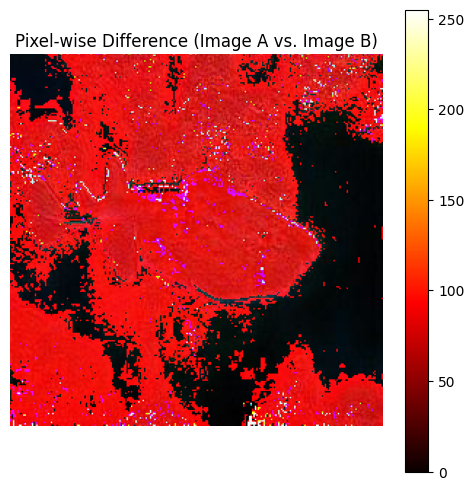

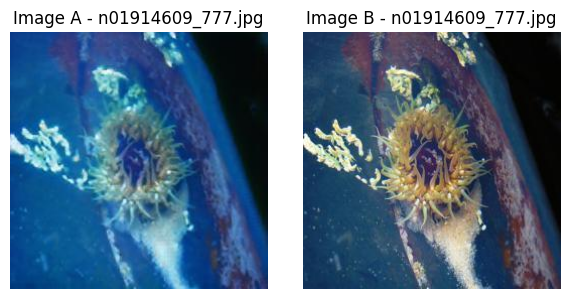

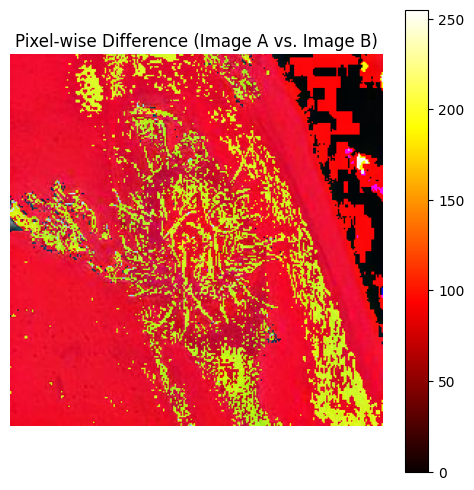

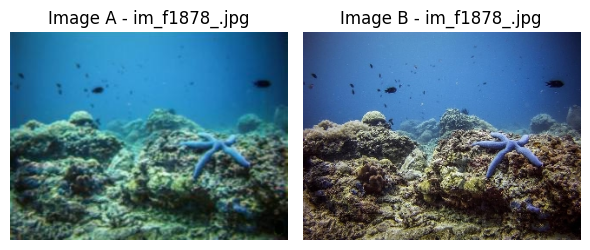

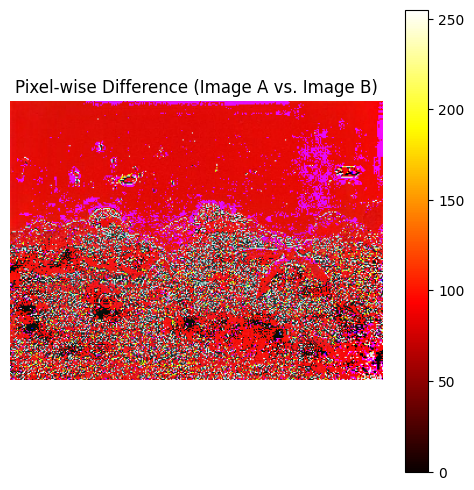

In [9]:
def visualize_pixel_diff(image_loader, index):
    """
    Visualizes the pixel-wise differences between Image A and Image B.
    """
    image_loader.display(index)
    imageA, imageB = image_loader[index]

    imageA_array = np.array(imageA)
    imageB_array = np.array(imageB)

    diff = np.abs(imageA_array - imageB_array)

    plt.figure(figsize=(6, 6))
    plt.imshow(diff, cmap='hot')
    plt.colorbar()
    plt.title(f'Pixel-wise Difference (Image A vs. Image B)')
    plt.axis('off')
    plt.show()

    
visualize_pixel_diff(image_loader, 0)

for i in random_indices:
    visualize_pixel_diff(image_loader, i)

Looking at the pixel-wise differences between Image A and Image B for the three pairs, we can see several notable variations.

First Pair (Image A: n01496331_1010.jpg and Image B: n01496331_1010.jpg): The pixel-wise difference map shows significant differences in certain areas of the image, particularly in the red and magenta regions. These areas likely indicate differences in lighting or color balance between the two images. The differences are spread out, but they mostly affect specific features of the image, such as the texture of the fish and surrounding environment.

Second Pair (Image A: n01914609_777.jpg and Image B: n01914609_777.jpg): The pixel-wise difference here also highlights strong color contrasts, with noticeable areas of difference in red and yellow tones. These variations could be caused by environmental conditions, underwater distortions, or different camera settings when capturing the images.

Third Pair (Image A: im_f1878_.jpg and Image B: im_f1878_.jpg): The difference map for this pair shows a more intense overall difference, especially in the red regions, suggesting significant shifts in color or brightness between the two images. This could point to lighting differences or processing changes applied to one of the images, which is common in image restoration tasks.

In general, the pixel-wise differences across all pairs show that there are notable variations in color, brightness, or overall quality between the images. These differences are useful for analyzing the impact of image restoration or enhancement techniques, especially in underwater imaging where light conditions can significantly affect the results.

## Pixel Intensities
Here, we show the distribution of pixel intensities for both the degraded and restored images. This analysis helps us understand the changes in brightness and contrast after restoration, showing how much light and dark areas are adjusted.

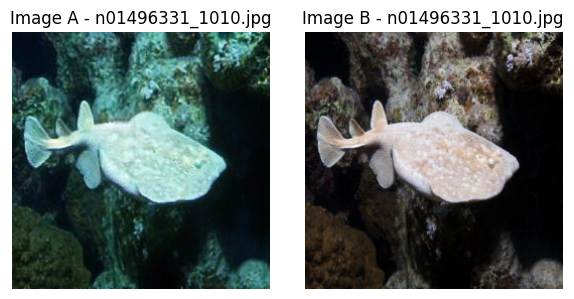

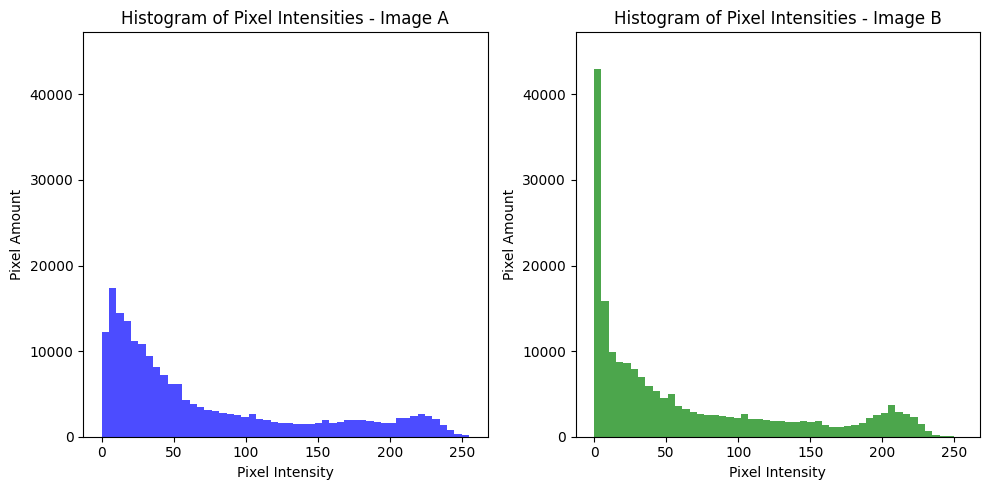

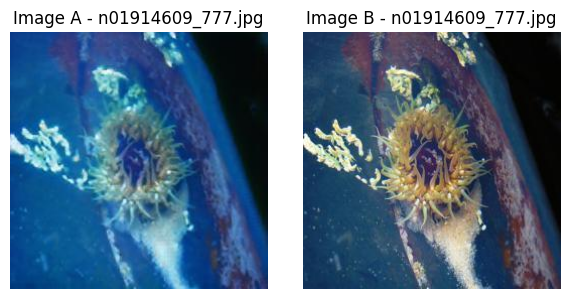

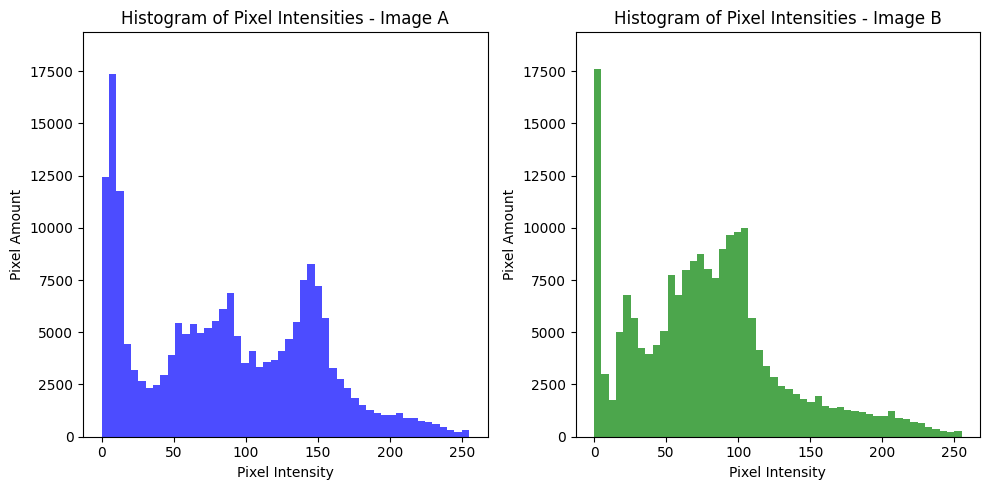

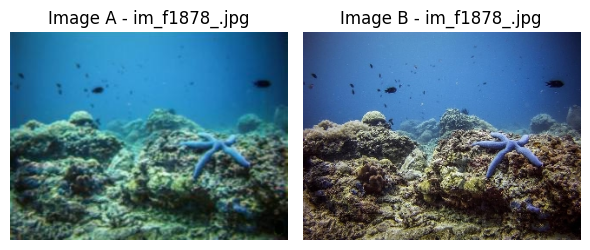

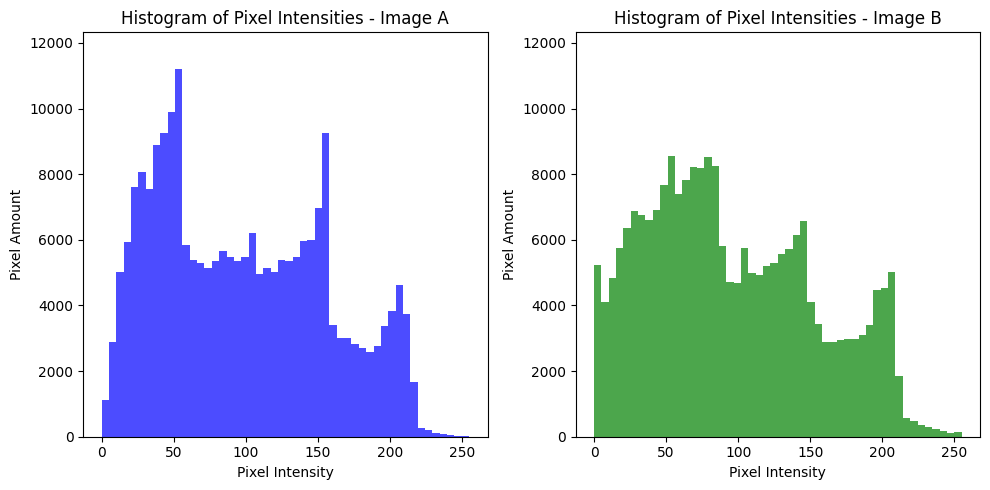

In [10]:
def plot_histogram(image_loader, index):
    """
    Plots histograms of pixel intensity for Image A and Image B.
    """
    image_loader.display(index)
    imageA, imageB = image_loader[index]

    imageA_array = np.array(imageA).flatten()
    imageB_array = np.array(imageB).flatten()

    histA, binsA = np.histogram(imageA_array, bins=50)
    histB, binsB = np.histogram(imageB_array, bins=50)
    max_freq = max(histA.max(), histB.max())

    y_max = max_freq * 1.1

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.hist(imageA_array, bins=50, color='blue', alpha=0.7)
    plt.title('Histogram of Pixel Intensities - Image A')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Pixel Amount')
    plt.ylim(0, y_max)

    plt.subplot(1, 2, 2)
    plt.hist(imageB_array, bins=50, color='green', alpha=0.7)
    plt.title('Histogram of Pixel Intensities - Image B')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Pixel Amount')
    plt.ylim(0, y_max)

    plt.tight_layout()
    plt.show()

plot_histogram(image_loader, 0)

for i in random_indices:
    plot_histogram(image_loader, i)

todo: write conclusion

## Brightness and Contrast
We compare the brightness (average pixel value) and contrast (standard deviation of pixel values) of the images. Underwater images often have low contrast, so understanding these changes is important for assessing the effectiveness of the restoration process.

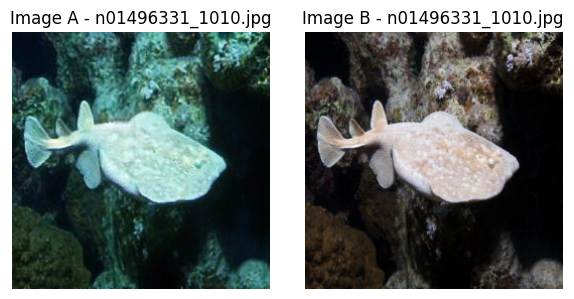

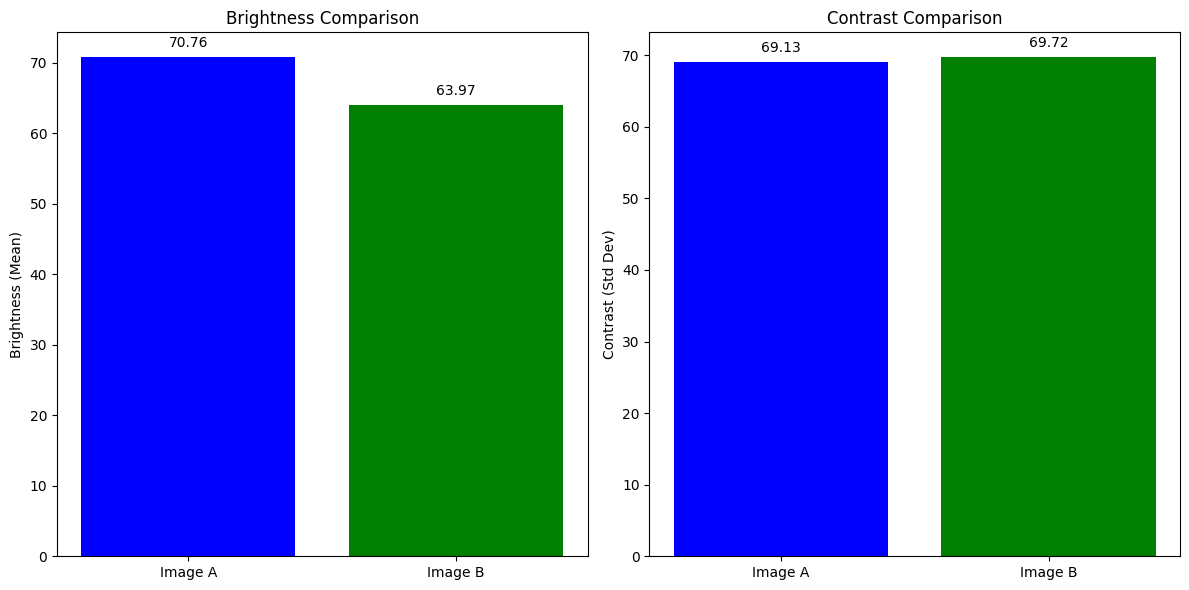

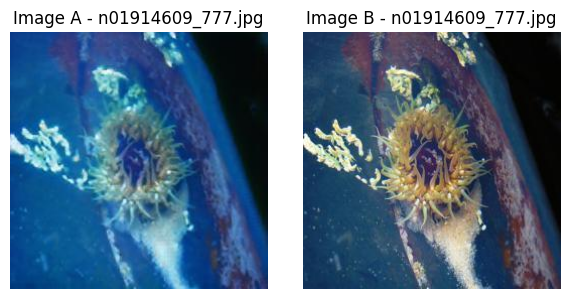

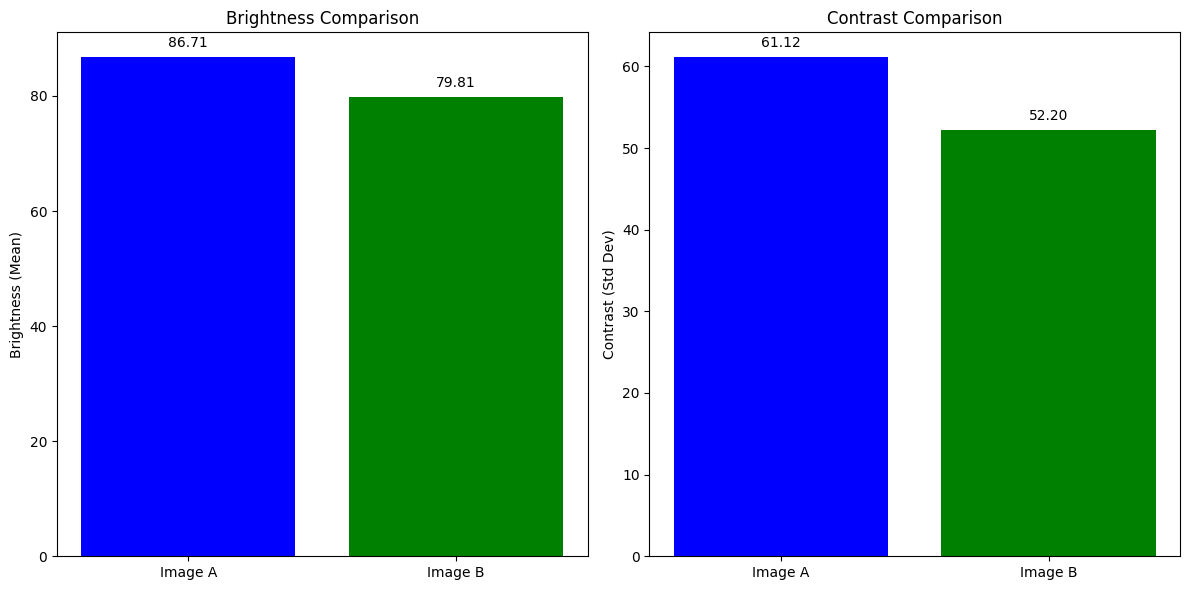

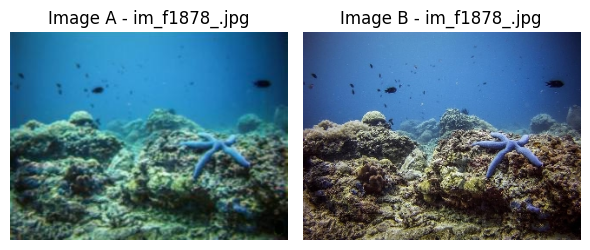

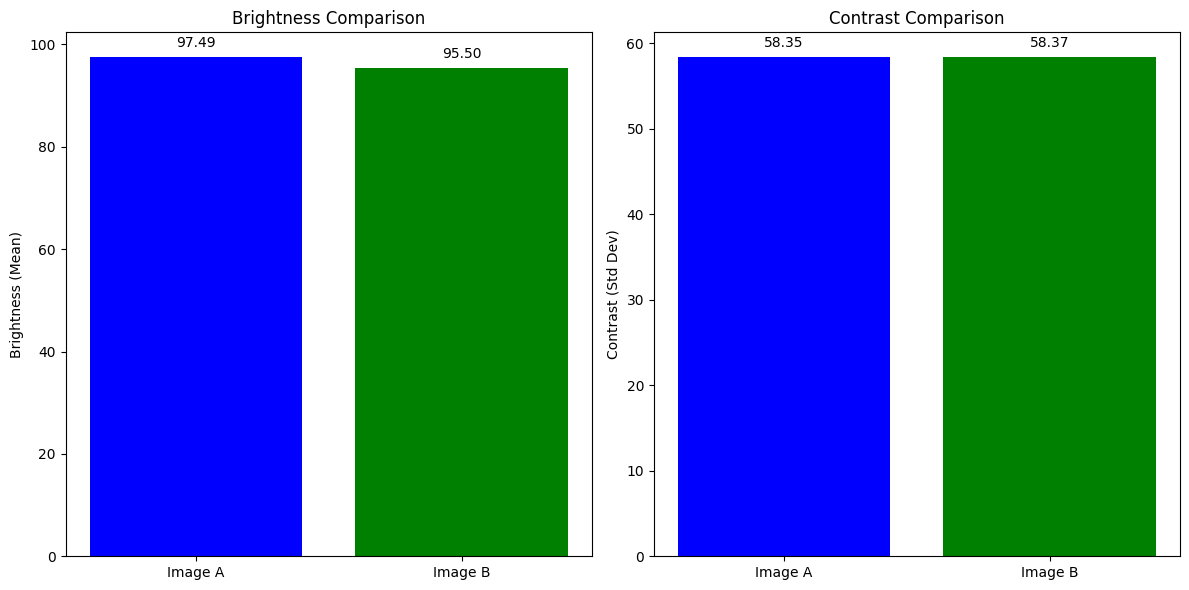

In [11]:
def compute_brightness_contrast(image_loader, index):
    """
    Computes brightness (mean pixel value) and contrast (std dev of pixel values)
    for both Image A and Image B.
    """
    image_loader.display(index)
    imageA, imageB = image_loader[index]

    imageA_array = np.array(imageA)
    imageB_array = np.array(imageB)

    brightnessA = np.mean(imageA_array)
    brightnessB = np.mean(imageB_array)

    contrastA = np.std(imageA_array)
    contrastB = np.std(imageB_array)

    labels = ['Image A', 'Image B']
    brightness_values = [brightnessA, brightnessB]
    contrast_values = [contrastA, contrastB]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    bars_brightness = axes[0].bar(labels, brightness_values, color=['blue', 'green'])
    axes[0].set_title('Brightness Comparison')
    axes[0].set_ylabel('Brightness (Mean)')

    for bar in bars_brightness:
        height = bar.get_height()
        axes[0].annotate(f'{height:.2f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 5),
                         textcoords='offset points',
                         ha='center', va='bottom')

    bars_contrast = axes[1].bar(labels, contrast_values, color=['blue', 'green'])
    axes[1].set_title('Contrast Comparison')
    axes[1].set_ylabel('Contrast (Std Dev)')

    for bar in bars_contrast:
        height = bar.get_height()
        axes[1].annotate(f'{height:.2f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 5),
                         textcoords='offset points',
                         ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

compute_brightness_contrast(image_loader, 0)

for i in random_indices:
    compute_brightness_contrast(image_loader, i)

The high quality images have lower brightness values compared to the low quality images. Contract stays relatively the same and in some cases, it seems to decrease.

## Color Distribution (RGB)
Underwater images tend to lose certain colors, particularly reds, due to light absorption. We analyze the red, green, and blue channels separately to understand how the color balance is affected and how the restoration process corrects these imbalances.

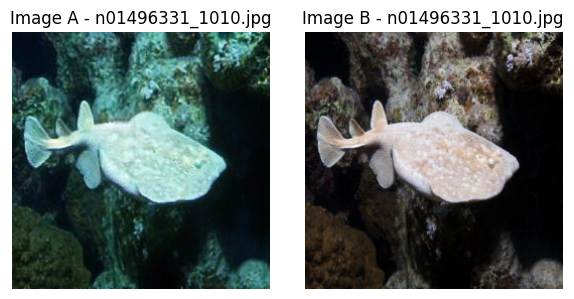

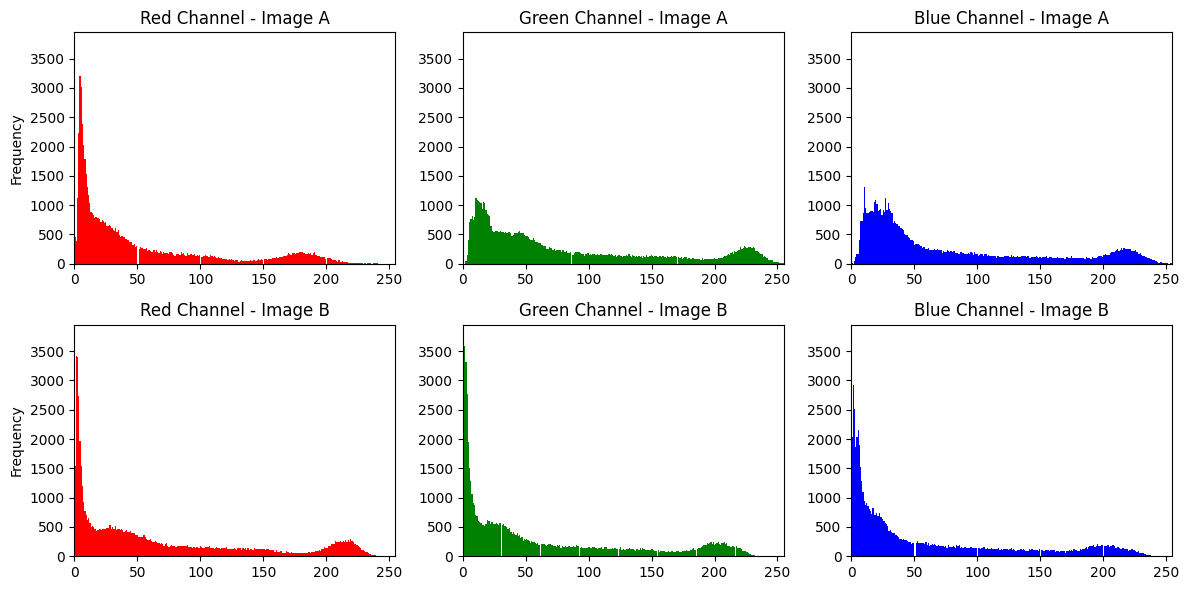

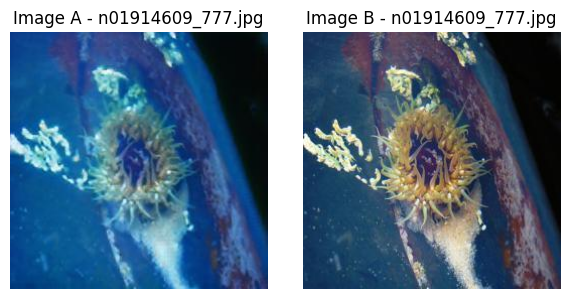

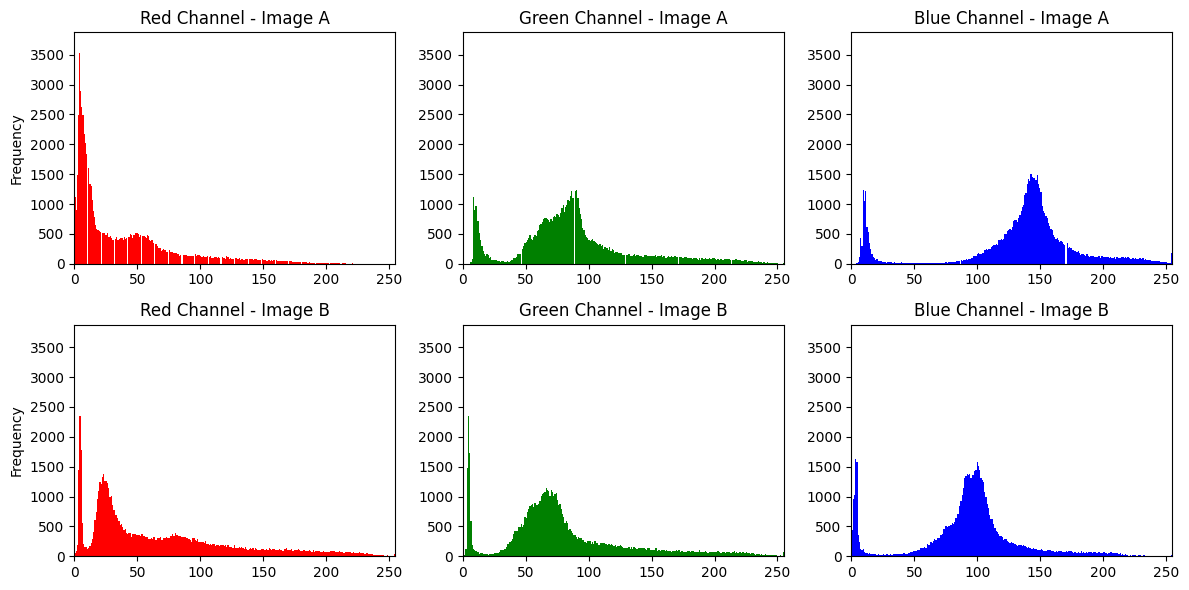

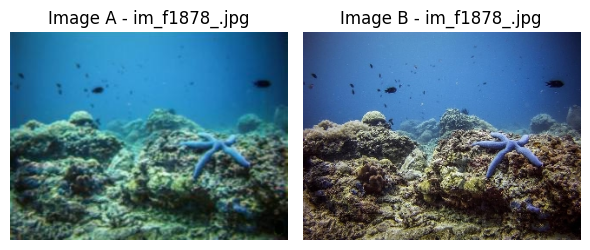

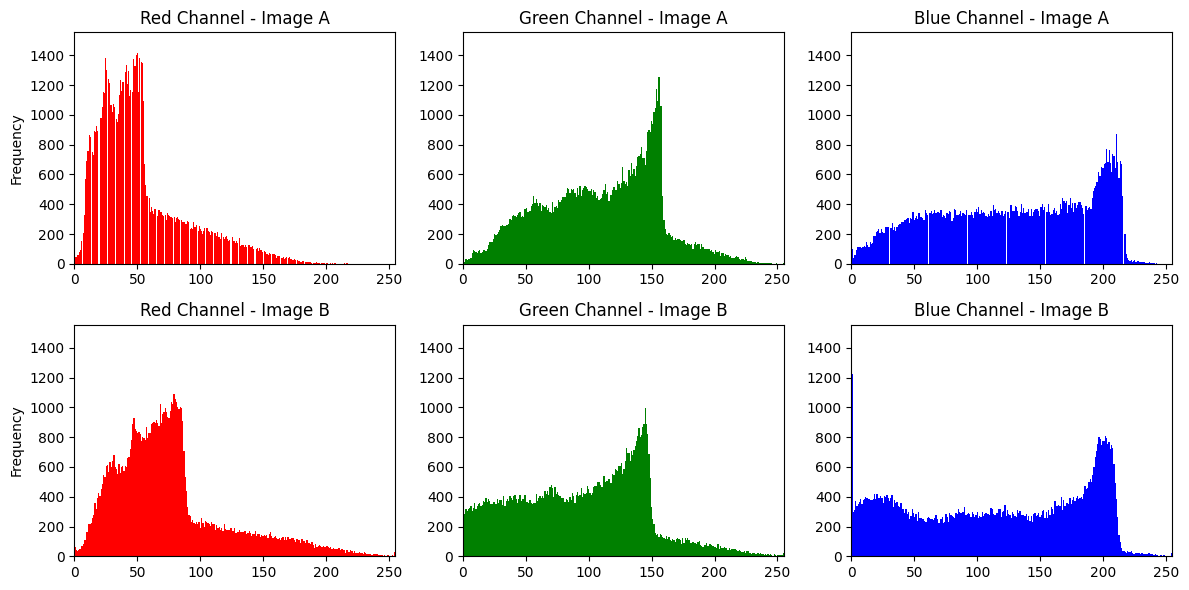

In [12]:
def plot_color_distribution(image_loader, idx):
    """
    Plots the color distribution (RGB) for Image A and Image B.
    """
    image_loader.display(idx)
    imageA, imageB = image_loader[idx]

    imageA_array = np.array(imageA)
    imageB_array = np.array(imageB)

    max_freq = 0
    for image in [imageA_array, imageB_array]:
        for i in range(3):  # Loop over R, G, B channels
            hist, _ = np.histogram(image[:, :, i].ravel(), bins=256)
            max_freq = max(max_freq, hist.max())

    y_max = max_freq * 1.1

    fig, axes = plt.subplots(2, 3, figsize=(12, 6))

    for i, color in enumerate(['Red', 'Green', 'Blue']):
        axes[0, i].hist(imageA_array[:, :, i].ravel(), bins=256, color=color.lower())
        axes[0, i].set_title(f'{color} Channel - Image A')
        axes[0, i].set_xlim(0, 255)
        axes[0, i].set_ylim(0, y_max)
    axes[0, 0].set_ylabel("Frequency")

    for i, color in enumerate(['Red', 'Green', 'Blue']):
        axes[1, i].hist(imageB_array[:, :, i].ravel(), bins=256, color=color.lower())
        axes[1, i].set_title(f'{color} Channel - Image B')
        axes[1, i].set_xlim(0, 255)
        axes[1, i].set_ylim(0, y_max)
    axes[1, 0].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

plot_color_distribution(image_loader, 0)

for i in random_indices:
    plot_color_distribution(image_loader, i)

## PSNR and SSIM (Evaluation Metrics)
In the next phase, we will compute PSNR (Peak Signal-to-Noise Ratio) and SSIM (Structural Similarity Index). PSNR measures image quality by comparing the restored image to the original, while SSIM evaluates perceived image similarity, focusing on structural details. These metrics will help quantify the effectiveness of the restoration process.

Calculating PSNR and SSIM: 100%|██████████| 11435/11435 [03:34<00:00, 53.19it/s]


PSNR Statistics: Mean = 17.07177614023265 Std Dev = 2.967579791981146
SSIM Statistics: Mean = 0.778268400328477 Std Dev = 0.09227447922500025


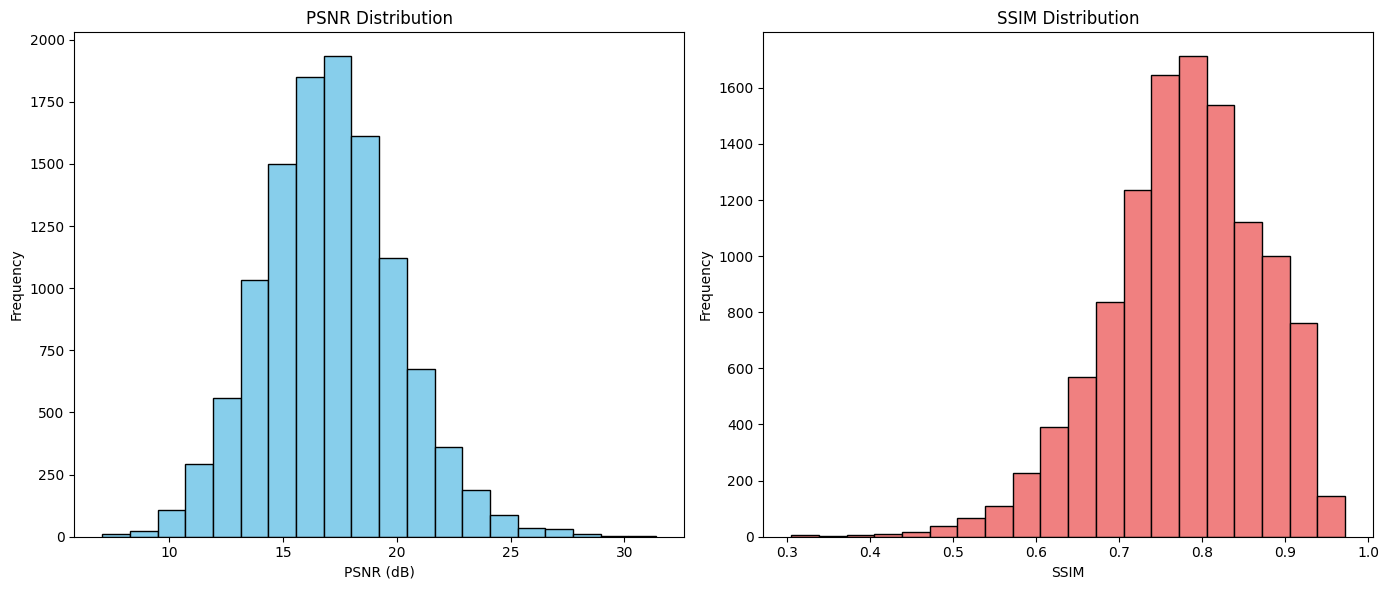

In [19]:
def calculate_metrics(image_loader):
    psnr_values = []
    ssim_values = []

    for i in tqdm(range(len(image_loader)), desc="Calculating PSNR and SSIM"):
        imageA, imageB = image_loader[i]
        imageA_array = np.array(imageA)
        imageB_array = np.array(imageB)

        # PSNR
        psnr = peak_signal_noise_ratio(imageA_array, imageB_array)
        psnr_values.append(psnr)

        # SSIM
        ssim = structural_similarity(imageA_array, imageB_array, channel_axis=2)
        ssim_values.append(ssim)

    return psnr_values, ssim_values

def plot_metrics_distribution(psnr_values, ssim_values):
    plt.figure(figsize=(14, 6))

    # PSNR Distribution
    plt.subplot(1, 2, 1)
    plt.hist(psnr_values, bins=20, color='skyblue', edgecolor='black')
    plt.title("PSNR Distribution")
    plt.xlabel("PSNR (dB)")
    plt.ylabel("Frequency")

    # SSIM Distribution
    plt.subplot(1, 2, 2)
    plt.hist(ssim_values, bins=20, color='lightcoral', edgecolor='black')
    plt.title("SSIM Distribution")
    plt.xlabel("SSIM")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

psnr_values, ssim_values = calculate_metrics(image_loader)

print("PSNR Statistics: Mean =", np.mean(psnr_values), "Std Dev =", np.std(psnr_values))
print("SSIM Statistics: Mean =", np.mean(ssim_values), "Std Dev =", np.std(ssim_values))

plot_metrics_distribution(psnr_values, ssim_values)

**PSNR:**

Low mean PSNR (17.07 dB) indicates that the images are noisy or have significant degradation. In general, the images are not very similar to their ideal originals.
The moderate standard deviation (2.97 dB) shows that there is some variability in image quality, meaning that some images are closer to the original while others are more degraded.

**SSIM:**

A mean SSIM of 0.78 shows that the image pairs are somewhat structurally similar but still have some differences. The similarity between the images might be moderate, but not perfect.
The low standard deviation (0.09) in SSIM indicates that the structural similarity between image pairs is consistent across the dataset. Most images have a similar level of perceptual quality.